<a href="https://colab.research.google.com/github/frdmu/neural-network/blob/main/%E9%A2%84%E6%B5%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#零.准备工作，设置GPU，按下面的三步提示做

1.点击上面的‘修改’菜单栏

2.选择‘笔记本设置’

3.‘硬件加速器’中选择'GPU',最后按‘保存’

# 一.下载源码

In [1]:
!git clone https://github.com/frdmu/neural-network

Cloning into 'neural-network'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 82 (delta 38), reused 45 (delta 14), pack-reused 0
Unpacking objects: 100% (82/82), done.


In [2]:
cd neural-network/

/content/neural-network


In [3]:
ls

data.tar.gz  LSSVMRegression.py  main.py  Readme.md  预测.ipynb


In [4]:
!tar -zxvf data.tar.gz

数据分类/
数据分类/测试集/
数据分类/测试集/1.升负荷.xlsx
数据分类/测试集/2.降负荷.xlsx
数据分类/测试集/3.稳定负荷.xlsx
数据分类/训练集/
数据分类/训练集/1.升负荷.xls
数据分类/训练集/2.降负荷.xls
数据分类/训练集/3.稳定负荷.xls


In [5]:
ls

data.tar.gz  LSSVMRegression.py  main.py  Readme.md  数据分类/  预测.ipynb


#二.程序

##1.导入库

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import LeaveOneOut, KFold

from LSSVMRegression import LSSVMRegression

## 2.加载数据

In [251]:
##################加载数据######################
def loadDataSet(fileName, flag=1): 
    global max_, min_
    df = pd.read_excel(fileName)   #读取数据
    df = df.dropna(axis=0)      #删除有空值的行
    #print("#"*50)
    #print(fileName, "前30行数据：") 
    #print("#"*50)
    #display(df.loc[0:30])        #显示前30行数据
    df_arr = np.array(df)
    row = df_arr.shape[0]
    col = df_arr.shape[1]
     
    #变量异常值处理
    for i in range(col-2):
      mean = np.mean(df_arr[:, i]) #Xi均值
      var = np.var(df_arr[:, i])  #Xi方差
      for j in range(row): 
        if (j > 0 and j < row-1 and np.absolute(df_arr[:, i][j] - mean) > 3*var):
          df_arr[:, i][j] = (df_arr[:, i][j-1] + df_arr[:, i][j+1])/2
    if flag: 
      #数据归一化
      max_ = df_arr.max(axis=0)
      min_ = df_arr.min(axis=0)
    df_arr = (df_arr - min_) / (max_ - min_)  
   
    #X为输入，y为输出, 其中y[:,0]为S02，y[:,1]为NOx
    X = df_arr[:, 0:-2] 
    y = df_arr[:, -2:]
    return X, y

In [252]:
X_train, y_train = loadDataSet('数据分类/训练集/1.升负荷.xls')
#X_test, y_test= loadDataSet('数据分类/测试集/1.升负荷.xlsx', 0)

##3.变量时滞确定

In [253]:
#print(X_train.shape, y_train.shape)
#print(X_train[:, 0])
#print(y_train[:, 0])

# 计算相关性
def calCorralation(a, b): 
  ab = np.array([a, b])
  dfab = pd.DataFrame(ab.T, columns=['A', 'B'])
  return dfab.A.corr(dfab.B)

###(1).确定SO2时滞

In [254]:
timeDelayStepS02 = []

for i in range(0, X_train.shape[1]):
  a = X_train[:, i]   #Xi表示某一列的变量
  b = y_train[:, 0]   #SO2 
  correlationList = []  #存放相关系数
  k = len(a)
  #print(k) 
  for n in range(1, k):   #样本移动步数n的范围是[1, k-1]
    a = np.delete(a, 0)   #Xi移动
    b = np.delete(b, -1)   #SO2移动
    correlationList.append([calCorralation(a, b), n]) #保存相关系数和移动步数
    if (len(correlationList) == 3):
      if (correlationList[0][0] < correlationList[1][0] and correlationList[1][0] > correlationList[2][0]):
        timeDelayStepS02.append(correlationList[1][1]) #找到变量Xi的时滞步数,继续处理下一个变量
        break
      else:
        del(correlationList[0])            #没有找到Xi的时滞步数,继续平移
print(timeDelayStepS02)
print(len(timeDelayStepS02))

[110, 109, 48, 41, 3, 16, 2, 41, 4, 16, 16, 24, 83, 13, 5, 62, 18, 28, 112, 2, 71, 103, 108, 94, 97, 2, 16, 97, 40, 22, 90, 32, 101, 91, 91, 135, 135, 23, 105, 105, 90]
41


###(2).确定NOx时滞

In [255]:
timeDelayStepNOx = []

for i in range(0, X_train.shape[1]):
  a = X_train[:, i]   #Xi表示某一列的变量
  b = y_train[:, 1]   #NOx 
  correlationList = []  #存放相关系数
  k = len(a)
  #print(k) 
  for n in range(1, k):   #样本移动步数n的范围是[1, k-1]
    a = np.delete(a, 0)   #Xi移动
    b = np.delete(b, -1)   #NOx移动
    correlationList.append([calCorralation(a, b), n]) #保存相关系数和移动步数
    if (len(correlationList) == 3):
      if (correlationList[0][0] < correlationList[1][0] and correlationList[1][0] > correlationList[2][0]):
        timeDelayStepNOx.append(correlationList[1][1]) #找到变量Xi的时滞步数,继续处理下一个变量
        break
      else:
        del(correlationList[0])            #没有找到Xi的时滞步数,继续平移
print(timeDelayStepNOx)
print(len(timeDelayStepNOx))

[80, 55, 28, 28, 53, 15, 29, 28, 195, 75, 75, 49, 53, 115, 13, 56, 66, 35, 36, 35, 85, 51, 55, 71, 70, 74, 63, 72, 30, 34, 70, 88, 77, 57, 81, 73, 73, 31, 59, 59, 59]
41


###(3).确定变量时滞后,根据变量时滞重新调整输入数据,并存入csv文件

In [317]:
def adjustInput(X_origin, y_origin, timeDelayStep, fileName):
  """
    X_origin: np.array
    y_origin: np.array
    timeDelayStep: np.array 
    fileName: 新的文件名
  """
  X_new = []
  stepMax = np.max(timeDelayStep)
  row = X_origin.shape[0]
  len = row - stepMax
  
  for i in range(timeDelayStep.shape[0]):
    x = np.delete(X_origin[:, i], np.s_[0: timeDelayStep[i]])
    if (x.shape[0] > len):
      x = np.delete(x, np.s_[len-x.shape[0] :])
    X_new.append(x.tolist())
  
  X_new = np.array(X_new)
  X_new = np.transpose(X_new)
  y_new = y_origin[0: len]
  y_new = y_new[:, np.newaxis] 
  data = np.concatenate((X_new, y_new), axis=1)
  data_new = pd.DataFrame(data)
  data_new.to_csv(fileName)
  print("file save done")

In [318]:
!pwd

/content/neural-network


In [319]:
adjustInput(X_train, y_train[:,0], np.array(timeDelayStepS02), '/content/neural-network/时滞确定后数据/训练集/1.升负荷SO2.csv')
adjustInput(X_train, y_train[:,1], np.array(timeDelayStepNOx), '/content/neural-network/时滞确定后数据/训练集/1.升负荷NOx.csv')

file save done
file save done


In [321]:
ls

data.tar.gz         main.py       Readme.md         数据分类/        预测.ipynb
LSSVMRegression.py  __pycache__/  RF_S02_top30.csv  时滞确定后数据/


In [322]:
cd 时滞确定后数据/训练集

/content/neural-network/时滞确定后数据/训练集


In [323]:
ls

1.升负荷NOx.csv  1.升负荷SO2.csv


In [324]:
cd ../..

/content/neural-network


##4.筛选变量

###一、随机森林筛选变量

In [325]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, csv

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

####(1).S02变量筛选,选取重要性排在前20的变量,筛选后的数据存入csv文件

(9532, 41) (9532,)
top20_indices [20 28 27 30 24 32 39 31 22 36 35 17 38 40 34 25 29 15 23  1 -2]
Feature ranking:
1. no.20 (0.169702)
2. no.28 (0.098121)
3. no.27 (0.065708)
4. no.30 (0.064951)
5. no.24 (0.060242)
6. no.32 (0.056221)
7. no.39 (0.056193)
8. no.31 (0.049705)
9. no.22 (0.046260)
10. no.36 (0.040834)
11. no.35 (0.034477)
12. no.17 (0.030395)
13. no.38 (0.028300)
14. no.40 (0.021594)
15. no.34 (0.020398)
16. no.25 (0.018592)
17. no.29 (0.018527)
18. no.15 (0.016971)
19. no.23 (0.015481)
20. no.1 (0.013563)


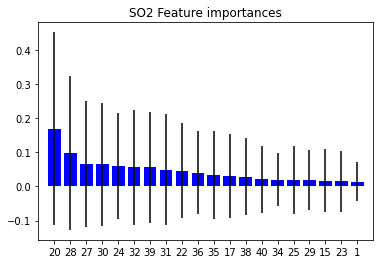

In [347]:
#筛选变量
fileName = '/content/neural-network/时滞确定后数据/训练集/1.升负荷SO2.csv'
df = pd.read_csv(fileName)
data = np.array(df)
data = data[:, 1:]

col_row = data.shape
row = col_row[0] 
col = col_row[1]

X= data[:,:-1]
Y= data[:,-1:] # S02
y=Y.ravel()
y1=y.astype(int)
print(X.shape, y1.shape)

forest = RandomForestClassifier()
forest.fit(X, y1)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
cut_indices = indices[0:20] #选取前20个重要的变量

header_indices = np.copy(cut_indices)
top20_indices = np.append(header_indices,[-2])
print("top20_indices", top20_indices)

#筛选完毕，数据存入文本
df = pd.read_csv(fileName)
out = df.iloc[:,top20_indices]
out.to_csv("/content/neural-network/变量筛选后数据/测试集/1.升负荷SO2.csv",index=False)

# Print the feature ranking
print("Feature ranking:")
for count in range(20):
    print("%d. no.%d (%f)" % (count+1, indices[count], importances[indices[count]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("SO2 Feature importances")
plt.bar(range(20), importances[cut_indices],color="b", yerr=std[cut_indices], align="center")
plt.xticks(range(20), cut_indices)
plt.xlim([-1, 20])
plt.show()   

In [350]:
more 1.升负荷SO2.csv

####(2).N0x变量筛选,选取重要性排在前30的变量,筛选后的数据存入RF_NOx_top30.csv

In [344]:
fileName = "/content/neural-network/neural-network/总数据整理.xls"
df = pd.read_excel(fileName)
data = np.array(df)
col_row = data.shape

row = 5000 #选取5000条数据进行变量筛选 
col = col_row[1]

X= data[0:row,1:col-2]
Y= data[0:row,col-1:col] # NOx 
y=Y.ravel()
y1=y.astype(int)

forest = RandomForestClassifier()
forest.fit(X, y1)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
cut_indices = indices[0:30] #选取前30个重要的变量

header_indices = np.copy(cut_indices)
top30_indices = np.append(header_indices,[-2])
#筛选完毕，存入文本
df = pd.read_excel(fileName)
out = df.iloc[:,top30_indices]
out.to_csv("/content/neural-network/RF_NOx_top30.csv",index=False)

# Print the feature ranking
print("Feature ranking:")
for count in range(30):
    print("%d. no.%d (%f)" % (count+1, indices[count], importances[indices[count]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("SO2 Feature importances")
plt.bar(range(30), importances[cut_indices],color="b", yerr=std[cut_indices], align="center")
plt.xticks(range(30), cut_indices)
plt.xlim([-1, 30])
plt.show()   

FileNotFoundError: ignored

##5.预测

###（1）.神经网络预测

In [ ]:
####################I.Neural Network Model#######################
    #建立模型并训练模型
def neuralNetwork(X_train, y_train, X_valid, y_valid):
    #输入数据的维度
    input_shape = X_train.shape[1]
    #输出数据的维度
    output_shape = y_train.shape[1]

    model = keras.Sequential([
        layers.BatchNormalization(input_shape=[input_shape]),	

        layers.Dense(units=1024, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),	

        layers.Dense(units=1024, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),	

        layers.Dense(units=1024, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),	

        layers.Dense(units=output_shape),
        ])

    model.compile(optimizer='adam', loss='mae', metrics=['mae'])

    early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        min_delta=0.001,
        restore_best_weights=True,
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        batch_size=256,
        epochs=50,
        callbacks=[early_stopping],
        verbose=1,# hide the output because we have so many epochs
    )

    #训练结果
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()

Epoch 1/50
101/101 [==============================] - 5s 10ms/step - loss: 0.8998 - mae: 0.8998 - val_loss: 0.1152 - val_mae: 0.1152
Epoch 2/50
101/101 [==============================] - 1s 6ms/step - loss: 0.2369 - mae: 0.2369 - val_loss: 0.1217 - val_mae: 0.1217
Epoch 3/50
101/101 [==============================] - 1s 6ms/step - loss: 0.1354 - mae: 0.1354 - val_loss: 0.1052 - val_mae: 0.1052
Epoch 4/50
101/101 [==============================] - 1s 5ms/step - loss: 0.1154 - mae: 0.1154 - val_loss: 0.0887 - val_mae: 0.0887
Epoch 5/50
101/101 [==============================] - 1s 5ms/step - loss: 0.1011 - mae: 0.1011 - val_loss: 0.0687 - val_mae: 0.0687
Epoch 6/50
101/101 [==============================] - 1s 5ms/step - loss: 0.0886 - mae: 0.0886 - val_loss: 0.0795 - val_mae: 0.0795
Epoch 7/50
101/101 [==============================] - 1s 5ms/step - loss: 0.0860 - mae: 0.0860 - val_loss: 0.0734 - val_mae: 0.0734
Epoch 8/50
101/101 [==============================] - 1s 5ms/step - loss: 0

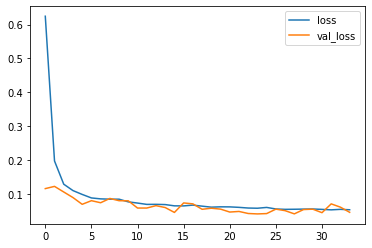

In [ ]:
neuralNetwork(X_train, y_train, X_valid, y_valid)

###（2）. 随机森林预测

In [ ]:
################II.Random Forest Model#######################
    #建立模型并训练模型
def randomForestRegressor(X_train, y_train, X_valid, y_valid): 
    rf=RandomForestRegressor()
    model = rf.fit(X_train, y_train)
    #在训练集上的拟合结果
    y_train_predict=model.predict(X_train)
    #展示在训练集上的表现
    plt.figure(1)
    drawSO2=pd.concat([pd.DataFrame(y_train[:, 0]),pd.DataFrame(y_train_predict[:, 0])],axis=1)
    drawSO2.iloc[:,0].plot(figsize=(12,6))
    drawSO2.iloc[:,1].plot(figsize=(12,6))
    plt.legend(('realSO2', 'predictSO2'),fontsize='15')
    plt.title("Train Data SO2 ",fontsize='30') #添加标题

    plt.figure(2)
    drawNOx=pd.concat([pd.DataFrame(y_train[:, 1]),pd.DataFrame(y_train_predict[:, 1])],axis=1)
    drawNOx.iloc[:,0].plot(figsize=(12,6))
    drawNOx.iloc[:,1].plot(figsize=(12,6))
    plt.legend(('realNOx', 'predictNOx'),fontsize='15')
    plt.title("Train Data NOx ",fontsize='30') #添加标题
 
    #在验证集上的预测
    y_valid_predict=model.predict(X_valid)
    #展示在验证集上的表现 
    plt.figure(3) 
    drawSO2=pd.concat([pd.DataFrame(y_valid[:, 0]),pd.DataFrame(y_valid_predict[:, 0])],axis=1);
    drawSO2.iloc[:,0].plot(figsize=(12,6))
    drawSO2.iloc[:,1].plot(figsize=(12,6))
    plt.legend(('realS02', 'predictSO2'),loc='upper right',fontsize='15')
    plt.title("Valid Data SO2",fontsize='30') #添加标 

    plt.figure(4)
    drawNOx=pd.concat([pd.DataFrame(y_valid[:, 1]),pd.DataFrame(y_valid_predict[:, 1])],axis=1);
    drawNOx.iloc[:,0].plot(figsize=(12,6))
    drawNOx.iloc[:,1].plot(figsize=(12,6))
    plt.legend(('realN0x', 'predictNOx'),loc='upper right',fontsize='15')
    plt.title("Valid Data NOx",fontsize='30') #添加标 
    
    print('训练集上的MAE/MSE')
    print(mean_absolute_error(y_train_predict, y_train))
    print(mean_squared_error(y_train_predict, y_train))
    print('验证集上的MAE/MSE')
    print(mean_absolute_error(y_valid_predict, y_valid))
    print(mean_squared_error(y_valid_predict, y_valid)) 

训练集上的MAE/MSE
0.007024079901053885
0.0001328776045089901
验证集上的MAE/MSE
0.018962628368629424
0.0009934581604072008


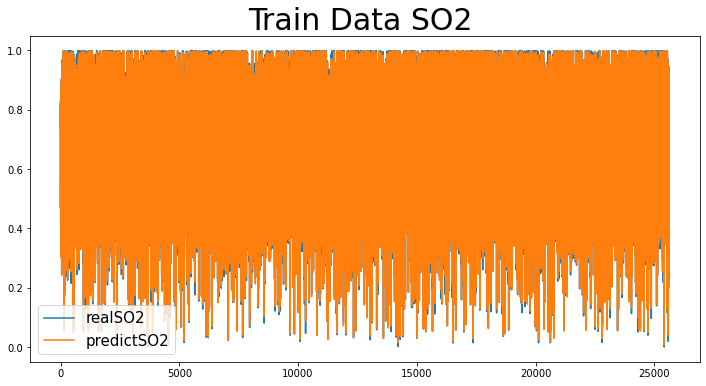

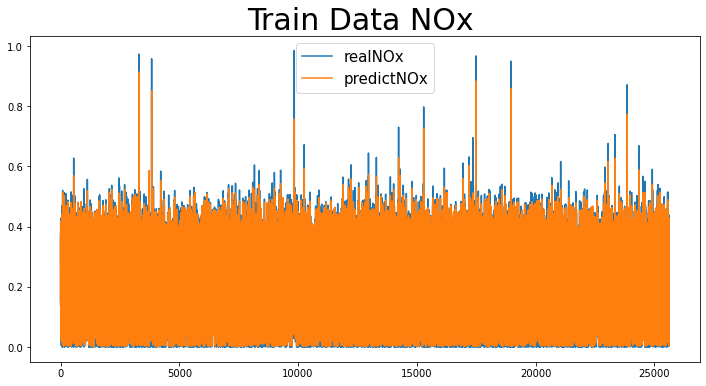

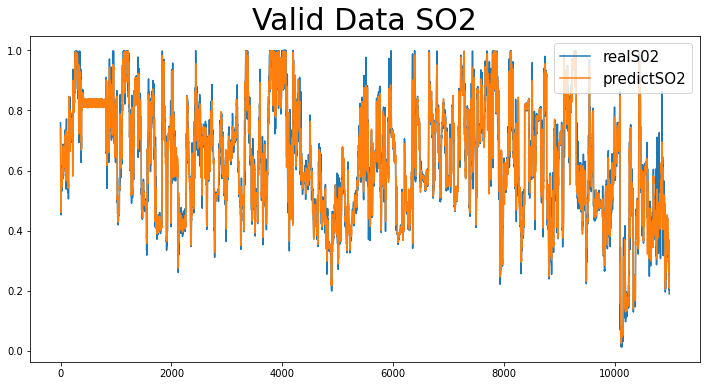

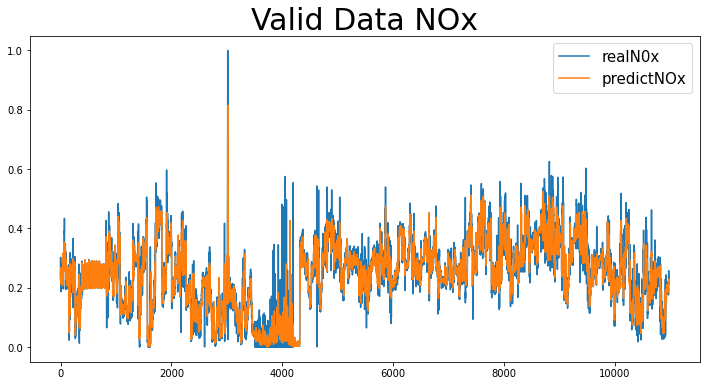

In [ ]:
randomForestRegressor(X_train, y_train, X_valid, y_valid)

###（3）.LSSVM预测

In [ ]:
################III.LSSVM#######################
    #建立模型并训练模型
def LSSVMRegressor(X_train, y_train, X_valid, y_valid): 
		#rbf-model
	clfrbf=LSSVMRegression(
        gamma=1.0,       #set the gamma-hyper parameter equal to 1
        kernel='poly',    #use the linear kernel
        sigma=1.0,
        c=1.0,
        d=3,
            )
	x = X_train[0:2000, :]
	y_0 = y_train[0:2000,0] # SO2
	y_1 = y_train[0:2000,1] # NOx
	
  # train model and predict for SO2
	clfrbf.fit(x, y_0)
	xPred=X_valid[0:1000, :]
	yExact=y_valid[0:1000, 0]
	yPred=clfrbf.predict(xPred)
	# The mean squared error
	print('Mean squared error: %.6f' % mean_squared_error(yExact, yPred))
	# The coefficient of determination: 1 is perfect prediction
	print('Coefficient of determination: %.6f' % r2_score(yExact, yPred))
	
	# train model and predict for NOx
	clfrbf.fit(x, y_1)
	yExact=y_valid[0:1000, 1]
	yPred=clfrbf.predict(xPred)
	# The mean squared error
	print('Mean squared error: %.6f' % mean_squared_error(yExact, yPred))
	# The coefficient of determination: 1 is perfect prediction
	print('Coefficient of determination: %.6f' % r2_score(yExact, yPred))

In [ ]:
LSSVMRegressor(X_train, y_train, X_valid, y_valid)

Mean squared error: 0.001962
Coefficient of determination: 0.816386
Mean squared error: 0.001952
Coefficient of determination: 0.532875
